In [1]:
!pip install gdown

In [60]:
import os
import cv2
import math
import glob
import gdown
import random
import zipfile
import logging
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from multiprocessing import Pool
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [5]:
# def download_file(url, output):
#     logging.info("Downloading file from the URL...")
#     try:
#         gdown.download(url, output, quiet=True)
#         logging.info("File downloaded successfully.")
#     except Exception as e:
#         logging.error("Error occurred during file download:", exc_info=True)
#         raise

In [6]:
# def extract_file(zip_path, extract_dir):
#     logging.info("Extracting file...")
#     try:
#         with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#             file_list = zip_ref.namelist()
#             with tqdm(total=len(file_list), desc='Extracting', unit='file') as pbar:
#                 zip_ref.extractall(extract_dir)
#                 pbar.update(len(file_list))
#         logging.info("Extraction completed successfully.")
#     except Exception as e:
#         logging.error("Error occurred during file extraction:", exc_info=True)
#         raise

In [7]:
# def download_and_extract(url, output, extract_dir):
#     try:
#         download_file(url, output)
#         extract_file(output, extract_dir)
#         logging.info("Download and extraction completed successfully.")
#     except Exception as e:
#         logging.error("An error occurred:", exc_info=True)
#         raise

In [8]:
# url = 'https://drive.google.com/uc?id=1l9sYu1jnRvFwTXte77mGew0fvopKYY3n'
# output = '/kaggle/working/dataset.zip' # kaggle
# output = '/content/dataset.zip' # colab
extract_dir = '/kaggle/input/crop-diseases-dataset' # kaggle
# extract_dir = '/content/crop-diseases-dataset' # colab
# extract_dir = 'crop-diseases-dataset'

# download_and_extract(url, output, extract_dir)

In [9]:
train_dir = os.path.join(extract_dir, 'train')
test_dir = os.path.join(extract_dir, 'test')

In [10]:
def count_images_in_dir(directory):
    num_images = sum(1 for _ in os.scandir(directory) if _.is_file())
    return num_images

In [11]:
def analyze_dataset():
    class_labels = os.listdir(train_dir)
    class_labels.sort()
    class_counts = []

    for i, class_label in enumerate(class_labels):
        train_class_dir = os.path.join(train_dir, class_label)
        test_class_dir = os.path.join(test_dir, class_label)

        num_train_images = count_images_in_dir(train_class_dir)
        num_test_images = count_images_in_dir(test_class_dir)

        class_counts.append([class_label, num_train_images, num_test_images])

    class_info = pd.DataFrame(class_counts, columns=['Class', 'Number of Train Images', 'Number of Test Images'])
    print(class_info)

    total_train_images = class_info['Number of Train Images'].sum()
    total_test_images = class_info['Number of Test Images'].sum()
    total_images = total_train_images + total_test_images

    print(f"Total number of train images: {total_train_images}")
    print(f"Total number of test images: {total_test_images}")
    print(f"Total number of images: {total_images}")

In [12]:
analyze_dataset()

                          Class  Number of Train Images  Number of Test Images
0            Corn___Common_Rust                    1192                    200
1         Corn___Gray_Leaf_Spot                     513                    200
2                Corn___Healthy                    1162                    200
3   Corn___Northern_Leaf_Blight                     985                    200
4         Potato___Early_Blight                    1000                    200
5              Potato___Healthy                     152                    152
6          Potato___Late_Blight                    1000                    200
7             Rice___Brown_Spot                     613                    200
8                Rice___Healthy                    1488                    200
9             Rice___Leaf_Blast                     977                    200
10            Rice___Neck_Blast                    1000                    200
11           Wheat___Brown_Rust                     

In [13]:
def load_images_from_dir(directory, image_paths_list, labels_list):
    class_labels = os.listdir(train_dir)
    class_labels.sort()
    for class_label in class_labels:
        class_dir = os.path.join(directory, class_label)

        if os.path.isdir(class_dir):
            image_files = [f.name for f in os.scandir(class_dir) if f.is_file()]
            image_paths_list.extend([os.path.join(class_dir, image_name) for image_name in image_files])
            labels_list.extend([class_label] * len(image_files))

In [14]:
labels = []
image_paths = []

load_images_from_dir(train_dir, image_paths, labels)
load_images_from_dir(test_dir, image_paths, labels)

In [15]:
class_dict = defaultdict(list)

for image_path, label in zip(image_paths, labels):
    class_dict[label].append(image_path)

In [16]:
label_counts = {}

for label, image_paths in class_dict.items():
    label_counts[label] = len(image_paths)

df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['Count'])

statistics = df.describe()
print(statistics)

             Count
count    14.000000
mean   1126.857143
std     333.477910
min     304.000000
25%    1107.500000
50%    1192.500000
75%    1287.000000
max    1688.000000


In [17]:
def label_encode(labels):
    label_encoder = LabelEncoder()
    integer_labels = label_encoder.fit_transform(labels)
    return integer_labels

In [18]:
def visualize_class_distribution(labels):
    class_counts = pd.Series(labels).value_counts().sort_index()
    integer_labels = label_encode(labels)
    unique_labels = np.unique(integer_labels)
    class_counts = class_counts.values

    plt.bar(unique_labels, class_counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()

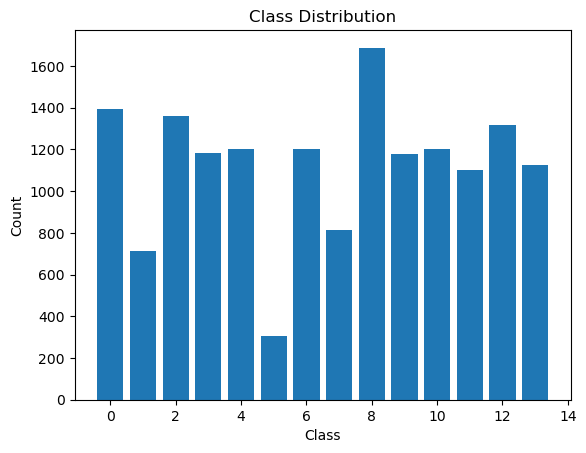

In [19]:
visualize_class_distribution(labels)

In [20]:
def get_dims(file):
    """Returns dimensions for an RGB image."""
    image = Image.open(file)
    width, height = image.size
    return width, height

In [21]:
def analyze_image_sizes(class_dict):
    for label, filepaths in class_dict.items():
        dims = []
        for filepath in filepaths:
            width, height = get_dims(filepath)
            dims.append((width, height))

        widths, heights = zip(*dims)
        df = pd.DataFrame({'width': widths, 'height': heights})
        sizes = df.groupby(['width', 'height']).size().reset_index().rename(columns={0: 'count'})

        fig, ax = plt.subplots()
        sns.scatterplot(data=sizes, x='width', y='height', ax=ax)
        ax.set_title('Image Sizes (pixels) | {}'.format(label))
        plt.show()

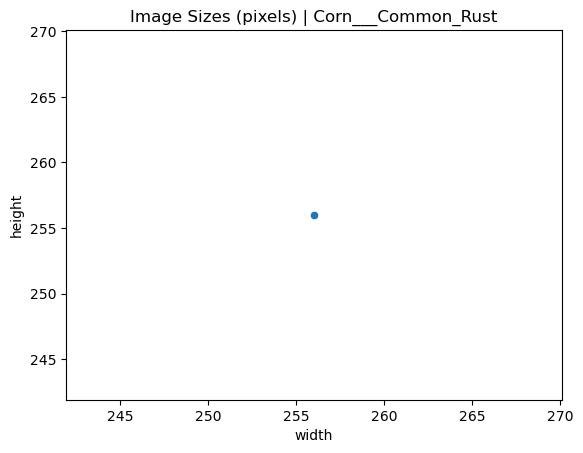

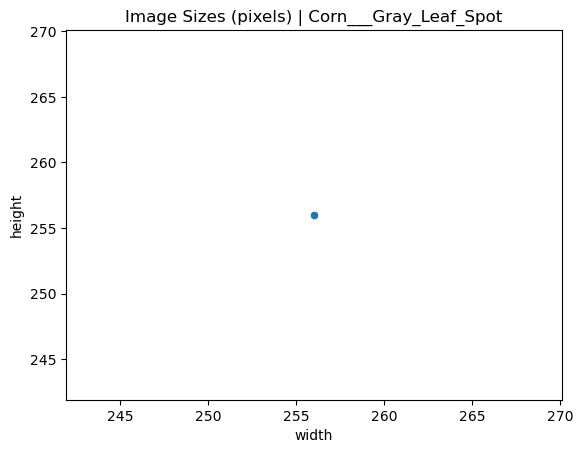

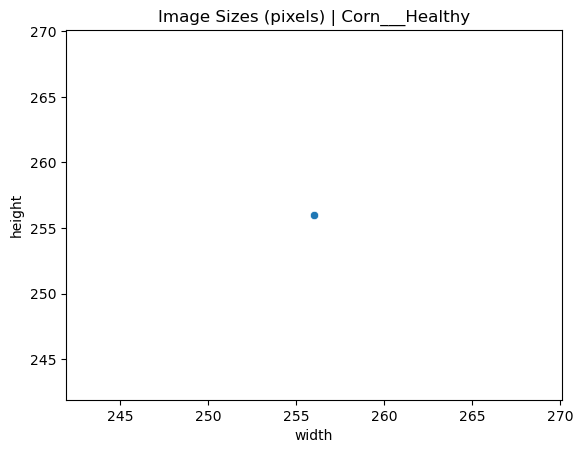

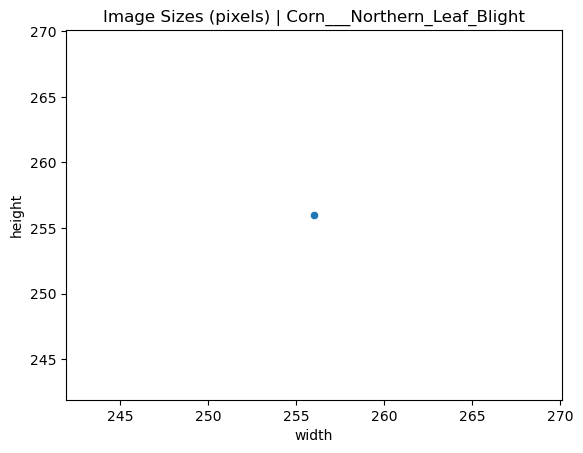

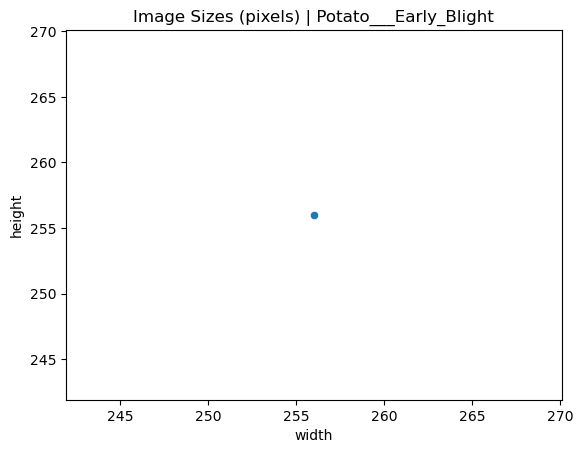

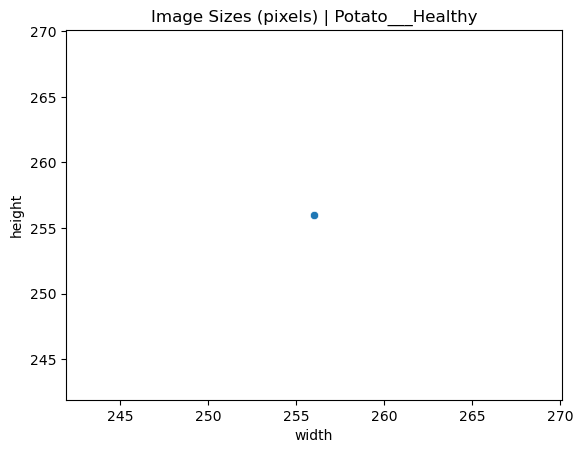

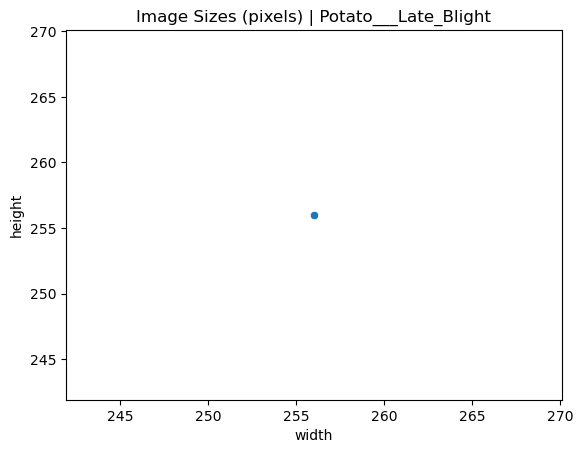

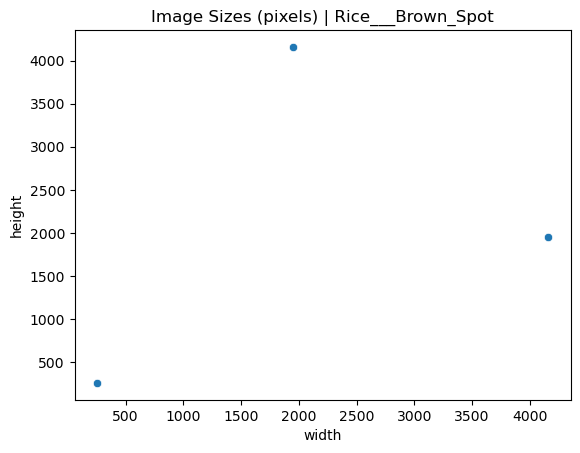

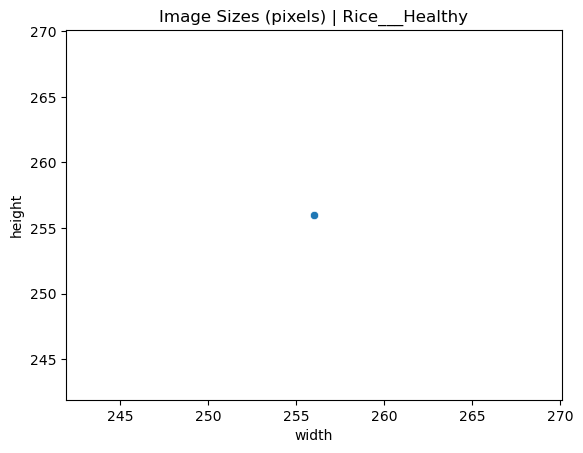

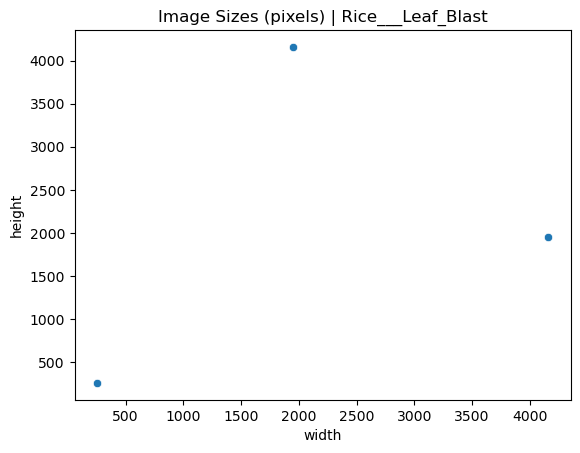

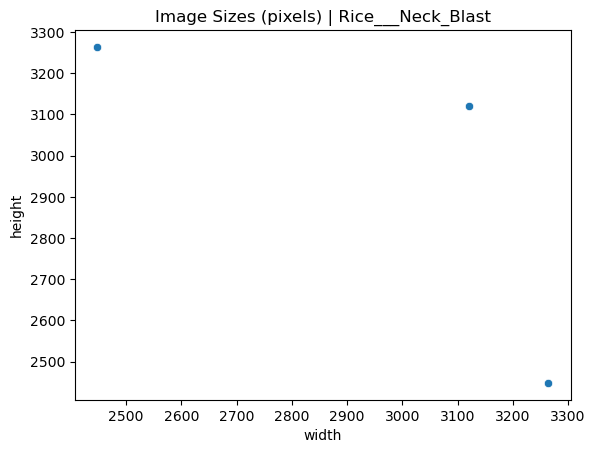

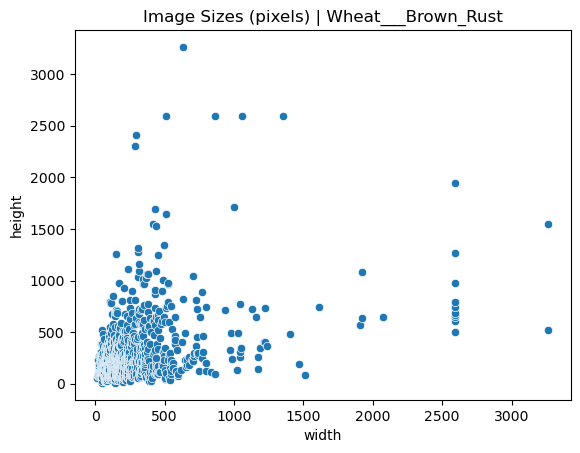

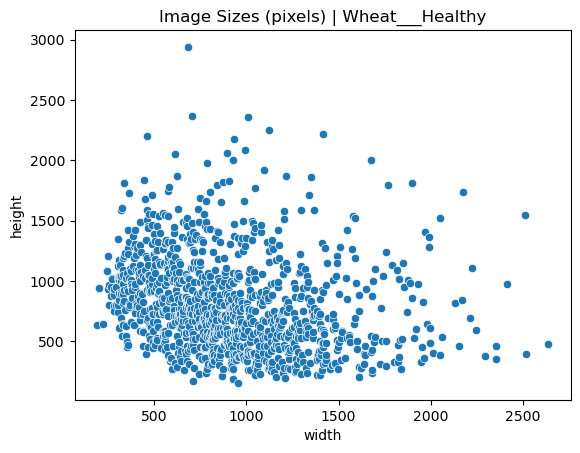

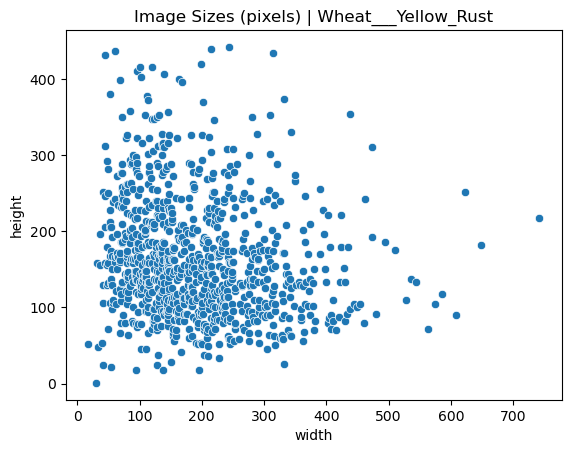

In [22]:
analyze_image_sizes(class_dict)

In [23]:
def visualize_class_images(class_dict):
    num_classes = len(class_dict)
    num_cols = math.ceil(math.sqrt(num_classes))
    num_rows = math.ceil(num_classes / num_cols)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6), squeeze=False)

    for i, (class_name, image_paths) in enumerate(class_dict.items()):
        random_image_path = random.choice(image_paths)

        row = i // num_cols
        col = i % num_cols

        image = Image.open(random_image_path)
        axes[row, col].imshow(image)
        axes[row, col].set_title(class_name)
        axes[row, col].axis('off')

    if num_classes < (num_rows * num_cols):
        for j in range(num_classes, (num_rows * num_cols)):
            row = j // num_cols
            col = j % num_cols
            fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()

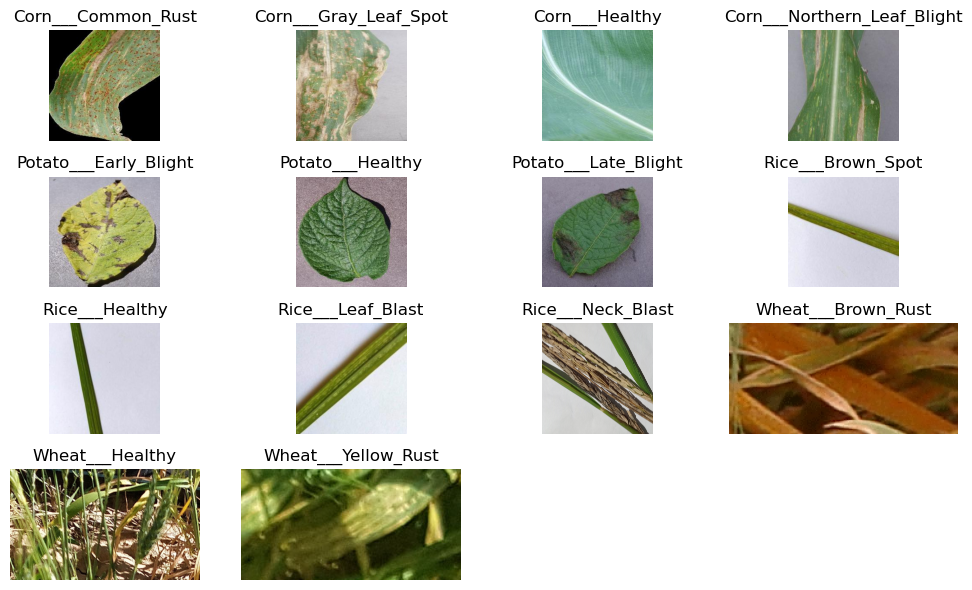

In [24]:
visualize_class_images(class_dict)

In [25]:
def process_image(image_path):
    image = cv2.imread(image_path)
    image_resized = cv2.resize(image, (256, 256))  # Resize images to a smaller size
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    flattened_image = image_rgb.reshape(-1, 3)
    unique_colors, color_counts = np.unique(flattened_image, axis=0, return_counts=True)
    return unique_colors, color_counts

In [26]:
def calculate_color_frequency(image_paths, labels, batch_size=100, num_processes=4):
    color_frequencies = defaultdict(int)

    with Pool(processes=num_processes) as pool:
        results = []
        for batch_start in tqdm(range(0, len(image_paths), batch_size), desc='Processing Batches'):
            batch_paths = image_paths[batch_start:batch_start+batch_size]
            batch_results = pool.map(process_image, batch_paths)
            results.extend(batch_results)

    for result in results:
        unique_colors, color_counts = result
        for color, count in zip(unique_colors, color_counts):
            color_tuple = tuple(color)
            color_frequencies[color_tuple] += count

    return color_frequencies

In [28]:
color_frequencies = calculate_color_frequency(image_paths, labels, batch_size=100, num_processes=4)

Processing Batches: 100%|██████████| 12/12 [01:57<00:00,  9.76s/it]


In [75]:
def plot_color_frequencies(color_frequencies, sample_size=None):
    colors, frequencies = zip(*color_frequencies.items())
    colors = np.array(colors) / 255.0
    frequencies = np.array(frequencies)

    if sample_size and sample_size < len(colors):
        indices = random.sample(range(len(colors)), sample_size)
        colors = colors[indices]
        frequencies = frequencies[indices]

    plt.figure(figsize=(8, 6))
    plt.scatter(range(len(colors)), frequencies, c=[colors[i] for i in tqdm(range(len(colors)), desc='Plotting Colors')])
    plt.xlabel('Color')
    plt.ylabel('Frequency')
    plt.title('Color Frequencies')
    plt.show()

Plotting Colors: 100%|██████████| 1000/1000 [00:00<00:00, 532272.08it/s]


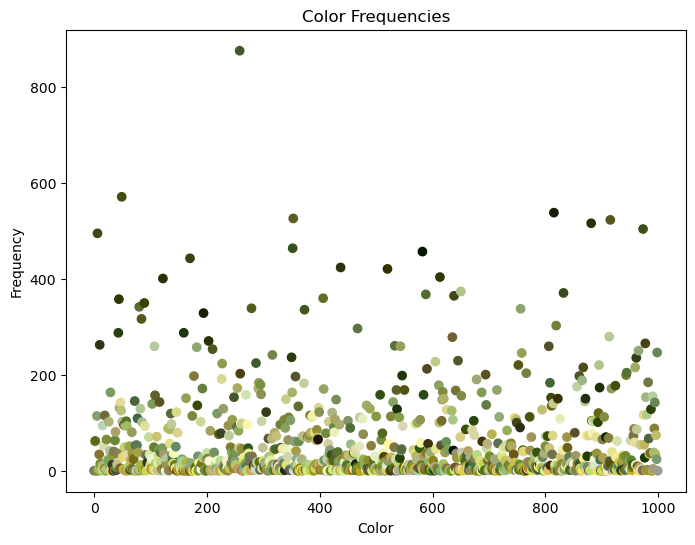

In [76]:
plot_color_frequencies(color_frequencies, sample_size=1000)

In [81]:
flattened_colors = np.array(list(color_frequencies.keys())) / 255.0
color_range = (np.min(flattened_colors, axis=0), np.max(flattened_colors, axis=0))

print("Most Common Colors:")
most_common_colors = sorted(color_frequencies.items(), key=lambda x: x[1], reverse=True)[:10]
for color, frequency in most_common_colors:
    print(f"{color}: {frequency}")
    
print("\nLeast Common Colors:")
least_common_colors = sorted(color_frequencies.items(), key=lambda x: x[1], reverse=False)[:10]
for color, frequency in least_common_colors:
    print(f"{color}: {frequency}")

Most Common Colors:
(19, 18, 0): 4069
(17, 14, 0): 3537
(29, 25, 0): 3350
(13, 16, 0): 3340
(41, 40, 10): 3158
(10, 19, 0): 3158
(18, 17, 0): 3013
(128, 157, 90): 3006
(18, 20, 0): 2906
(16, 14, 0): 2894

Least Common Colors:
(4, 31, 2): 1
(23, 55, 15): 1
(25, 57, 17): 1
(28, 63, 19): 1
(30, 65, 21): 1
(30, 66, 24): 1
(31, 67, 25): 1
(32, 68, 26): 1
(48, 85, 0): 1
(52, 89, 3): 1
